## Synchronization of active colloids in a 2D lattice of harmonic traps

Here, we study the dynamics of spherical active colloids of radius $b$ in a two-dimensional lattice of traps. We consider self-propelling, polar, achiral active colloids, with non-zero values of $\mathbf{V}_{i}^{\mathcal{A}}, \mathbf{V}_{i}^{(2s)}$ and $\mathbf{V}_{i}^{(3t)}$.  With this choice, an isolated colloid translates with velocity $\mathbf{V}_{i}^{\mathcal{A}}=v_{s}\boldsymbol{p}_{i}$ while producing dipolar and quadrupolar flows of strengths proportional to $\mathbf{V}_{i}^{(2s)}$ and $\mathbf{V}_{i}^{(3t)}$ respectively. 

The system we study can be realized experimentally in holographic tweezers. The centers of the $N$ traps are at $\boldsymbol{R}_{i}^{0}$, arranged linearly or in a $\sqrt{N}\times\sqrt{N}$ square lattice. Each trap contains a single active colloid which feels a body force from that trap alone. The moment of force about the trap center is zero. Therefore, in a trap of stiffness $k$ centered at $\boldsymbol{R}_{i}^{0}$, the force and torque on the ith colloid is

$$
\mathbf{F}_{i}^{P}=-k(\boldsymbol{R}_{i}-\boldsymbol{R}_{i}^{0}),\qquad\mathbf{T}_{i}^{P}=0.
$$

We start by ignoring hydrodynamic interactions to obtain the balance of forces and torques 

$$
-6\pi\eta b(\mathbf{V}_{i}-v_{s}\boldsymbol{p}_{i})-k(\boldsymbol{R}_{i}-\boldsymbol{R}^{0})	=0,	\qquad-8\pi\eta b^{3}\,\mathbf{\Omega}_{i}=0.
$$

This gives the confinement radius $R^{*}=6\pi\eta bv_{s}/k=\mathcal{A}_{T}b$, when the propulsive and trap forces are balanced. This is the stable state of the system in absence of hydrodynamic interactions. We now study the effects of hydrodynamic interaction using PyStokes. More details of the model etc can be found in section VII of the [paper](https://arxiv.org/pdf/1603.05735.pdf).  

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pystokes

In [2]:
DTYPE   = np.float64
class trap:
    def __init__(self, a, N, vs, eta, dim, S0, D0, k, ljeps, ljrmin):
        self.a      = a
        self.N     = N
        self.vs     = vs
        self.eta    = eta
        self.dim    = dim
        self.S0     = S0
        self.D0     = D0
        self.mu     = 1.0/(6*np.pi*self.eta*self.a)
        self.k      = k
        self.ljrmin = ljrmin
        self.ljeps  = ljeps
        self.dX = np.zeros( 6*self.N, dtype=DTYPE)
   
        self.uRbm = pystokes.unbounded.Rbm(self.a, self.N, self.eta)


    def initialise(self, initialConfig, trapCentre):
        self.rp0 = initialConfig
        self.trapCentre = trapCentre
        return

    def rhs(self, rp):
        N = self.N 
        xx=2*N; vs = self.vs
            
        r = rp[0:3*N]
        p = rp[3*N:6*N] 
        F = - self.k*(r-trapCentre)
            
        v = r*0; o=r*0;
        self.uRbm.mobilityTT(v, r, F)
        self.uRbm.mobilityRT(o, r, F)
    
        self.dX[0:3*N] = vs*p + v 
        self.dX[3*N:4*N] = o[N:2*N  ]*p[2*N:3*N] - o[2*N:3*N]*p[N:2*N]
        self.dX[4*N:5*N] = o[2*N:3*N]*p[0:N     ] - o[0:N     ]*p[2*N:3*N]
        self.dX[5*N:6*N] = o[0:N     ]*p[N:2*N  ] - o[N:2*N  ]*p[0:N   ]
        return self.dX
    
    def simulate(self, dt, N):
        '''run simulation and save data'''
        X = np.zeros( (N+1, 6*self.N), dtype=DTYPE)
        X[0, :] = self.rp0

        for i in range(N):
            X[i+1, :] =  X[i, :] + self.rhs(X[i, :])*dt
        
        sio.savemat('N=%s_vs=%4.4f_K=%4.4f.mat'%(self.N, self.vs, self.k), {'trapCentre':self.trapCentre, 'X':X, 't':dt, 'N':self.N,'k':self.k, 'vs':self.vs, 'S0':self.S0,})
        return

In [3]:
## parameters and initial conditions
N = 9          # number of particles
vs = 1         # self-propulsion speed
A  = 2          # number vs/k
k  = vs/A       # stiffness of the trap
a0 = 40         # separation of trap centers

dim = 3         # dimensionality of the problem 
eta = 1.0/6     # viscosity of the fluid simulated
b   = 1          # radius of the particle     

S0, D0        = 0.01, 0.01     # strength of the stresslet and potDiple
ljrmin, ljeps = 3, .01         # lennard-jones parameters
dt, Nts      = 10, 200        # final time and number of points 

# instantiate the class trap from trap.pyx for simulation                    
rm = trap(b, N, vs, eta, dim, S0, D0, k, ljeps, ljrmin)    

# set initial condition
def initialConfig(rp0, trapCentre, theta, b, a0, vs, k, N):                                              
    '''method for preparing an initial system'''                                                                           
    rr = (6*np.pi*eta*vs*b)/k  # confinement radius
    t1 = np.pi/180       
            
    if N==1:                                                                                             
        rp0[0], rp0[1], rp0[2] = 0, 0, 8    # Position                                          
        rp0[3], rp0[4], rp0[5] = 0, 0, -1   # Orientation                                                 
                
    elif N==3: 
        trapCentre[0], trapCentre[3]  =  0, 0                                                                                
        trapCentre[1], trapCentre[4] =  a0, a0
        trapCentre[2], trapCentre[5] = -a0, a0                                                          
        theta[0:3] = 90*np.pi/180                                                                                
        for i in range(N):
            rp0[i     ] = trapCentre[i   ] + rr*np.cos(theta[i])
            rp0[i+N  ] = trapCentre[i+N] + rr*np.sin(theta[i])
            rp0[i+3*N] = np.cos(theta[i])
            rp0[i+4*N] = np.sin(theta[i])
    else:
        N1d = np.int32(np.round( (N)**(1.0/2)))
        nnd = N1d/2 - 0.5; h0=0
        N= np.int32(N1d*N1d)
        for i in range(N1d):
            for j in range(N1d):
                    ii                  = i*N1d + j
                    trapCentre[ii]      = a0*(-nnd + i)
                    trapCentre[ii+N]   = a0*(-nnd + j)
                    trapCentre[ii+2*N] = h0
        theta = np.ones(N)*np.pi/2
        #theta = np.random.random(N)*np.pi/2
        for i in range(N):
            rp0[i     ] = trapCentre[i   ] + rr*np.cos(theta[i])
            rp0[i+N  ] = trapCentre[i+N] + rr*np.sin(theta[i])
            rp0[i+3*N] = np.cos(theta[i])
            rp0[i+4*N] = np.sin(theta[i])
            
rp0        = np.zeros(6*N)   # memory allocation for positions and orientation of colloids
trapCentre = np.zeros(3*N)   # memory allocation for trap centers
theta      = np.zeros(N)     # angle of the colloids about the trap centers

initialConfig(rp0, trapCentre, theta, b, a0, vs, k, N)
rm.initialise(rp0, trapCentre)

In [4]:
# simulate the system and save data
rm.simulate(dt, Nts)

### Load the data and plot snapshots

In [5]:
%matplotlib inline

data  = sio.loadmat('N=9_vs=1.0000_K=0.5000.mat')
X     = data['X']
tm    = data['t']
k     = data['k']
vs    = data['vs']
N    = data['N']
tC    = data['trapCentre']

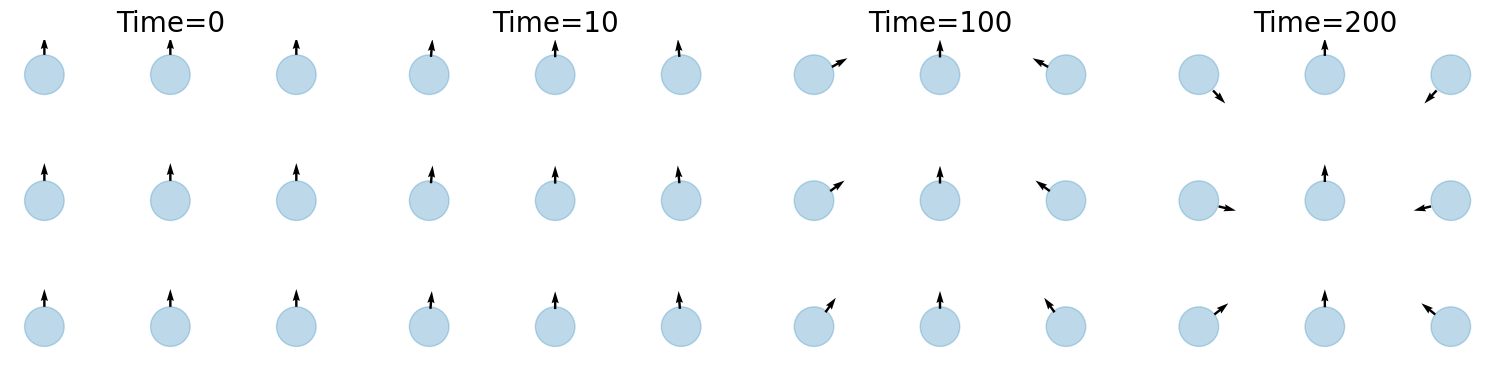

In [6]:
rr = (6*np.pi*eta*vs*b)/k  # confinement radius
fig = plt.figure(figsize=(24, 8)); 

def plotConfig(n, n_):
    ax = fig.add_subplot(1, 5, n_, aspect='equal', )
    for i in range(int(N)):
        ax.add_patch(patches.Circle((tC[0, i], tC[0, i+N]), rr, color='#348abd', alpha=0.32))
        x, y   = X[n,i], X[n,N+i]
        px, py = X[n,3*N+i], X[n,4*N+i]
        plt.quiver(x,y,px,py)
    plt.title('Time=%d'%n, fontsize=20); plt.axis('off')

plotConfig(0, 1)
plotConfig(10, 2)
plotConfig(100, 3)
plotConfig(200, 4)